# CONTEXTO

En este notebook se presentan los pasos para construir un modelo de clasificación de imágenes de tensores utilizando el conjunto de datos de Rayos X de pecho, la tarea es automatizar el proceso de detección y clasificación de las enfermedades.

Nos han entregado un conjunto de 133 imágenes de 4 clases: COVID-19, PNEUMONIA BACTERIANA, PNEUMONIA VIRICA y NORMAL

#IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [1]:
# Importar las librerías necesarias

import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [9]:
# Importar el conjunto de datos, los datos se toman de manera local

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
# Especificar el directorio del conjunto de entrenamiento

XRay_Directory = "contenido local"



In [11]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['1', '0', '3', '2']

In [ ]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior

image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [ ]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "training")


Found 428 images belonging to 4 classes.


In [ ]:
# cargamos las imágenes del directorio de entrenamiento y generamos los lotes de imágenes con sus respectivas etiquetas
#para su uso en el entrenamiento y la validación del modelo

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "validation")

Found 104 images belonging to 4 classes.


In [ ]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape  # Verificamos las dimensiones del lote

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]],

In [ ]:
# Creamos un diccionario para asignar las etiquetas a las carpetas dadas

label_names = {0: 'COVID-19', 1: 'NORMAL', 2: 'PNEUMONIA VIRICA', 3: 'PNEUMONIA BACTERIANA'}
label_names

{0: 'COVID-19', 1: 'NORMAL', 2: 'PNEUMONIA VIRICA', 3: 'PNEUMONIA BACTERIANA'}

# VISUALIZACIÓN DEL DATASET

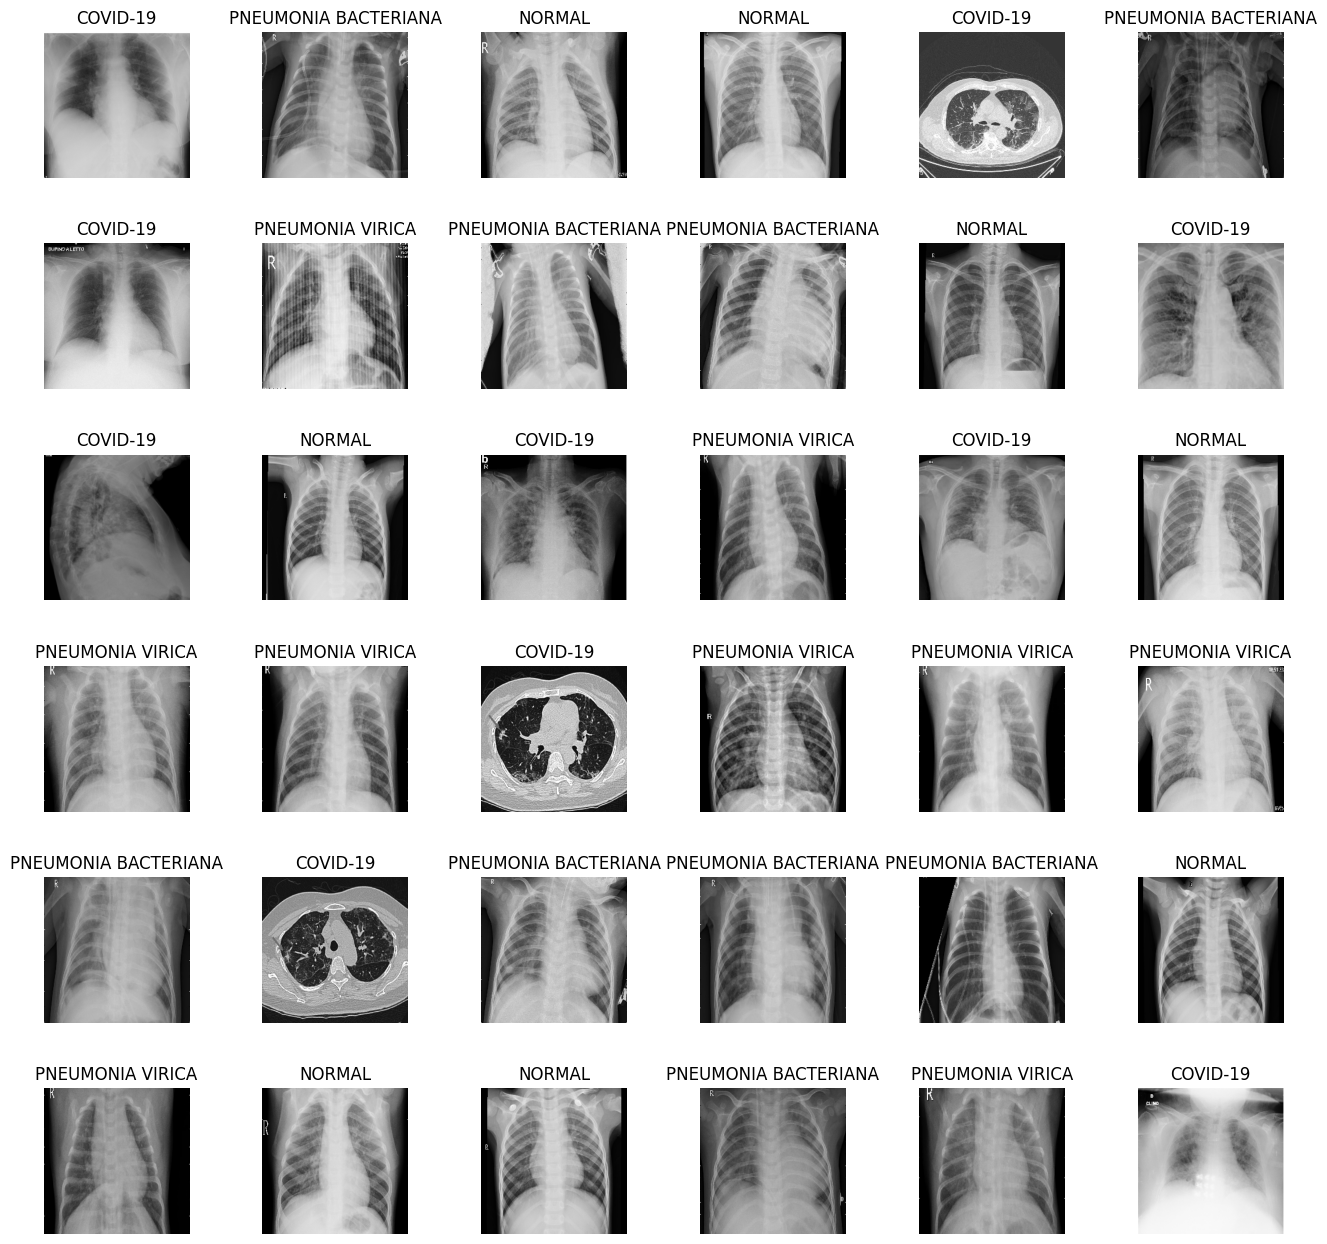

In [ ]:
# Creamos una matriz de 36 imágenes junto con sus etiquetas correspondientes
L = 6
W = 6

# Crear una figura de subtramas (subplots) con L filas y W columnas, con un tamaño total de (16, 16) pulgadas
fig, axes = plt.subplots(L, W, figsize=(16, 16))

# Aplanar la matriz de subtramas en un arreglo 1D para facilitar el acceso a cada subtrama por índice
axes = axes.ravel()

# Iterar sobre el rango de índices de las subtramas (0 a L * W - 1)
for i in np.arange(0, L * W):
    # Mostrar la i-ésima imagen de entrenamiento en la subtrama correspondiente
    axes[i].imshow(train_images[i])

    # Establecer el título de la subtrama con el nombre de la clase asociada a la i-ésima imagen
    # Utiliza np.argmax(train_labels[i]) para obtener el índice de la clase con mayor probabilidad en el one-hot encoding de la etiqueta
    axes[i].set_title(label_names[np.argmax(train_labels[i])])

    # Desactivar los ejes (axis) para no mostrar los valores de las coordenadas en la visualización
    axes[i].axis('off')

# Ajustar el espaciado horizontal entre las subtramas para mejorar la legibilidad
plt.subplots_adjust(wspace=0.5)

# Mostrar la visualización de las imágenes con sus etiquetas
plt.show()


#IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS - MobileNetV2

In [12]:
# Crear el modelo, se crea variable basemodel que contiene la instancia del modelo MobileNetV2 creado con estos parámetros.

basemodel = MobileNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary() # Observamos el detalle del modelo

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Verificamos la cantidad de capas del modelo

capas = basemodel.layers
num_layers = len(capas)
print("Número de capas del modelo:", num_layers)

Número de capas del modelo: 154


In [ ]:
# Congelar el modelo hasta las últimas etapas y llevar a cabo un re-entrenamiento
for layer in basemodel.layers[:-10]:
  layer.trainable = False


#CONSTRUIR Y ENTRENAR EL MODELO

In [ ]:
# Se asigna la salida del modelo base (basemodel) a la variable 'headmodel'.
# Esto contendrá las salidas de la última capa de la CNN pre-entrenada.
headmodel = basemodel.output

# Se aplica una capa de Average Pooling 2D para reducir la dimensión espacial de los mapas de características.
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)

# Se aplica una capa de aplanado (Flatten) para convertir los mapas de características 2D en un vector unidimensional.
headmodel = Flatten(name='flatten')(headmodel)

# Se añade una capa totalmente conectada (Dense) con 256 neuronas y función de activación ReLU.
headmodel = Dense(256, activation='relu')(headmodel)

# Se aplica la técnica de Dropout para desactivar aleatoriamente el 30% de las neuronas durante el entrenamiento.
headmodel = Dropout(0.3)(headmodel)

# Se añade otra capa totalmente conectada (Dense) con 128 neuronas y función de activación ReLU.
headmodel = Dense(128, activation='relu')(headmodel)

# Se aplica nuevamente la técnica de Dropout, esta vez con un valor del 20%.
headmodel = Dropout(0.2)(headmodel)

# Se añade la capa de salida con 4 neuronas y función de activación softmax para la clasificación multiclase.
headmodel = Dense(4, activation='softmax')(headmodel)

# Se crea el modelo completo uniendo el modelo base (basemodel) y la nueva arquitectura construida en la parte superior (headmodel).
model = Model(inputs=basemodel.input, outputs=headmodel)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# OBSERVAMOS EL NÚMERO DE CAPAS DEL MODELO
capas = model.layers
num_layers = len(capas)
print("Número de capas del modelo:", num_layers)

Número de capas del modelo: 161


In [ ]:
# compilamos el  modelo utilizando la función de pérdida de entropía cruzada categórica, el optimizador RMSprop con
# una tasa de aprendizaje de 1e-4 y una regularización mediante decay, y evalúa el rendimiento utilizando la métrica de precisión.

from keras.optimizers import RMSprop

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(learning_rate = 1e-4,  decay = 1e-6), metrics = ['accuracy'])


In [ ]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye
# incluso después de ciertos epochs
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only=True)

In [ ]:
# Crear un generador de imágenes para el entrenamiento
train_generator = image_generator.flow_from_directory(
    batch_size=4,                   # Tamaño del lote (batch size) para el entrenamiento
    directory=XRay_Directory,       # Directorio que contiene las imágenes de entrenamiento
    shuffle=True,                   # Mezclar las imágenes antes de cada época de entrenamiento
    target_size=(256, 256),         # Tamaño al que se redimensionarán las imágenes
    class_mode="categorical",       # Modo de codificación de las etiquetas (categorical para one-hot encoding)
    subset="training"               # Utilizar el conjunto de entrenamiento
)

# Crear un generador de imágenes para la validación
val_generator = image_generator.flow_from_directory(
    batch_size=4,                   # Tamaño del lote (batch size) para la validación
    directory=XRay_Directory,       # Directorio que contiene las imágenes de validación
    shuffle=True,                   # Mezclar las imágenes antes de cada época de validación
    target_size=(256, 256),         # Tamaño al que se redimensionarán las imágenes
    class_mode="categorical",       # Modo de codificación de las etiquetas (categorical para one-hot encoding)
    subset="validation"             # Utilizar el conjunto de validación
)


Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
# Entrenar el modelo utilizando el generador de entrenamiento y el generador de validación
# Además, se utilizan callbacks para guardar los pesos del modelo en el mejor punto durante el entrenamiento y
# para detener el entrenamiento tempranamente si no hay mejoras significativas


history = model.fit_generator(
    train_generator,                             # Generador de entrenamiento
    steps_per_epoch=train_generator.n // 4,      # Número de pasos por época (número total de imágenes de entrenamiento // tamaño del lote de entrenamiento)
    epochs=10,                                   # Número de épocas (iteraciones completas sobre todo el conjunto de entrenamiento)
    validation_data=val_generator,               # Generador de validación
    validation_steps=val_generator.n // 4,        # Número de pasos de validación (número total de imágenes de validación // tamaño del lote de validación)
    callbacks=[checkpointer, earlystopping]      # Lista de callbacks que se utilizarán durante el entrenamiento
)


<ipython-input-24-d7d40be34cca>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.9288 - accuracy: 0.6355
Epoch 1: val_loss improved from inf to 0.80425, saving model to weights.hdf5
107/107 [==============================] - 204s 2s/step - loss: 0.9288 - accuracy: 0.6355 - val_loss: 0.8043 - val_accuracy: 0.6923
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.8341
Epoch 2: val_loss did not improve from 0.80425
107/107 [==============================] - 8s 71ms/step - loss: 0.4881 - accuracy: 0.8341 - val_loss: 0.8656 - val_accuracy: 0.6731
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9322
Epoch 3: val_loss did not improve from 0.80425
107/107 [==============================] - 9s 83ms/step - loss: 0.2063 - accuracy: 0.9322 - val_loss: 1.0605 - val_accuracy: 0.6250
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9065
Epoch 4: val_loss improved from 0.80425 to 0.5163

In [ ]:
# Aumentamos los epochs a 30 para obtener mejores resultados

history1 = model.fit_generator(train_generator, steps_per_epoch = train_generator.n // 4, epochs = 30,
                              validation_data = val_generator, validation_steps = val_generator.n // 4,
                              callbacks = [checkpointer, earlystopping])

Epoch 1/30
  1/107 [..............................] - ETA: 6s - loss: 5.1400e-04 - accuracy: 1.0000

<ipython-input-25-773cd6f51f71>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(train_generator, steps_per_epoch = train_generator.n // 4, epochs = 30,


107/107 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9953
Epoch 1: val_loss did not improve from 0.51638
107/107 [==============================] - 9s 85ms/step - loss: 0.0212 - accuracy: 0.9953 - val_loss: 0.6860 - val_accuracy: 0.8462
Epoch 2/30
107/107 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9813
Epoch 2: val_loss did not improve from 0.51638
107/107 [==============================] - 8s 76ms/step - loss: 0.0340 - accuracy: 0.9813 - val_loss: 0.8968 - val_accuracy: 0.8462
Epoch 3/30
107/107 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9977
Epoch 3: val_loss did not improve from 0.51638
107/107 [==============================] - 9s 86ms/step - loss: 0.0133 - accuracy: 0.9977 - val_loss: 1.0019 - val_accuracy: 0.8173
Epoch 4/30
107/107 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9953
Epoch 4: val_loss did not improve from 0.51638
107/107 [==============================] - 

In [ ]:
# con 10 epochs:  loss: 0.2714 - accuracy: 0.9065 - val_loss: 0.5164 - val_accuracy: 0.8269

# En este caso observamos que no hubo mejora

#EVALUAR EL MODELO ENTRENADO

In [ ]:
history1.history.keys()   #Observamos las keys del historial

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

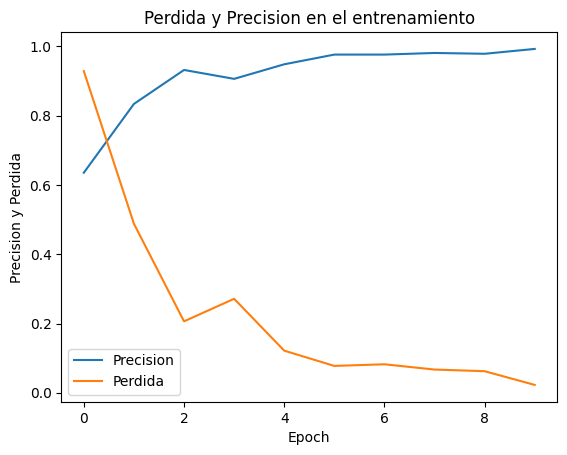

In [ ]:
# Realizamos la grafica del primer entrenamiento

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Perdida y Precision en el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Precision y Perdida')
plt.legend(['Precision', 'Perdida'])

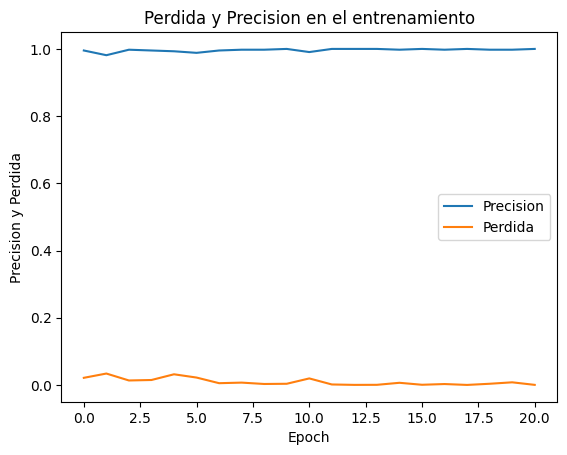

In [ ]:
# Realizamos la grafica del segundo entrenamiento

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'])

plt.title('Perdida y Precision en el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Precision y Perdida')
plt.legend(['Precision', 'Perdida'])

#Observamos que tenemos mejores resultados en la validación

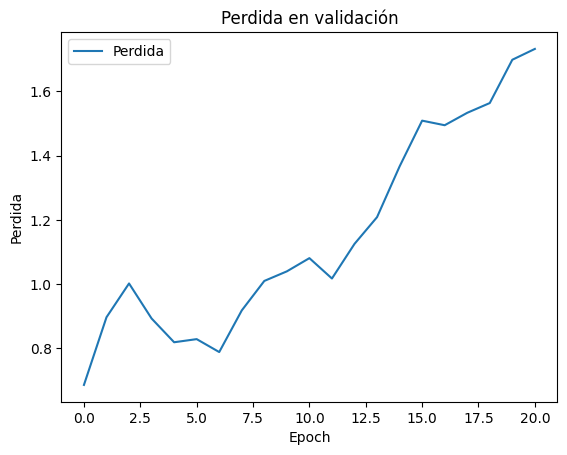

In [ ]:
# Crear un gráfico de línea que muestra la pérdida en validación durante el entrenamiento del modelo
plt.plot(history1.history['val_loss'])

plt.title('Perdida en validación')
plt.xlabel('Epoch')
plt.ylabel('Perdida')
plt.legend(['Perdida'])

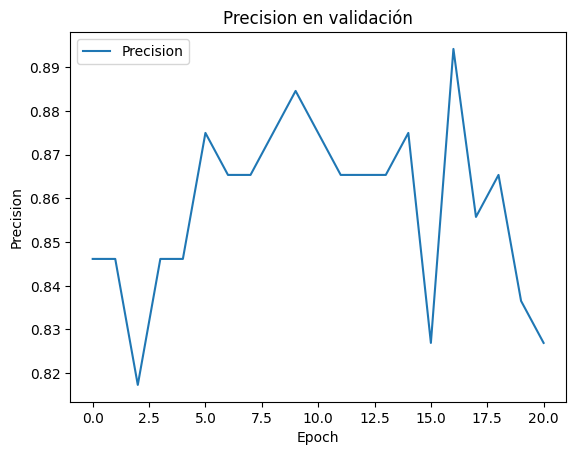

In [ ]:
# Crear un gráfico de línea que muestra la precisión en validación durante el entrenamiento del modelo

plt.plot(history1.history['val_accuracy'])

plt.title('Precision en validación')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Precision'])

In [13]:
#Utilizamos el modelo entrenado para predecir la etiqueta de la imagen de test

test_directory = "Carpeta local"


In [ ]:
# Creamos el modelo de test

test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True,
                                              target_size = (256, 256), class_mode = "categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print('Precision en la fase de Test:  {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


<ipython-input-32-238c0b3da68c>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)


 1/10 [==>...........................] - ETA: 31s - loss: 2.0800 - accuracy: 0.8000

10/10 [==============================] - 4s 34ms/step - loss: 2.0800 - accuracy: 0.8000
Precision en la fase de Test:  0.800000011920929


In [ ]:
# Importar las funciones necesarias de scikit-learn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Inicializar listas para almacenar las predicciones, las clases originales y las imágenes
predictions = []
original = []
image = []

# Recorrer cada carpeta en el directorio de prueba (cada carpeta representa una clase)
for i in range(len(os.listdir(test_directory))):
  # Recorrer cada archivo de imagen dentro de la carpeta actual (clase)
  for item in os.listdir(os.path.join(test_directory, str(i))):
    # Leer la imagen utilizando OpenCV y redimensionarla a 256x256 píxeles
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    # Agregar la imagen a la lista "image"
    image.append(img)
    # Normalizar los valores de los píxeles de la imagen al rango [0, 1]
    img = img / 255
    # Reorganizar la forma de la imagen para que coincida con el formato de entrada del modelo
    img = img.reshape(-1, 256, 256, 3)
    # Realizar la predicción utilizando el modelo
    predic = model.predict(img)
    # Obtener el índice de la clase con mayor probabilidad como la predicción
    predic = np.argmax(predic)
    # Agregar la predicción y la clase original a las listas correspondientes
    predictions.append(predic)
    original.append(i)


1/1 [==============================] - 0s 24ms/step


In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original, predictions)


In [ ]:
print("Precision del modelo: {:.2f}%".format(score * 100))

Precision del modelo: 77.50%


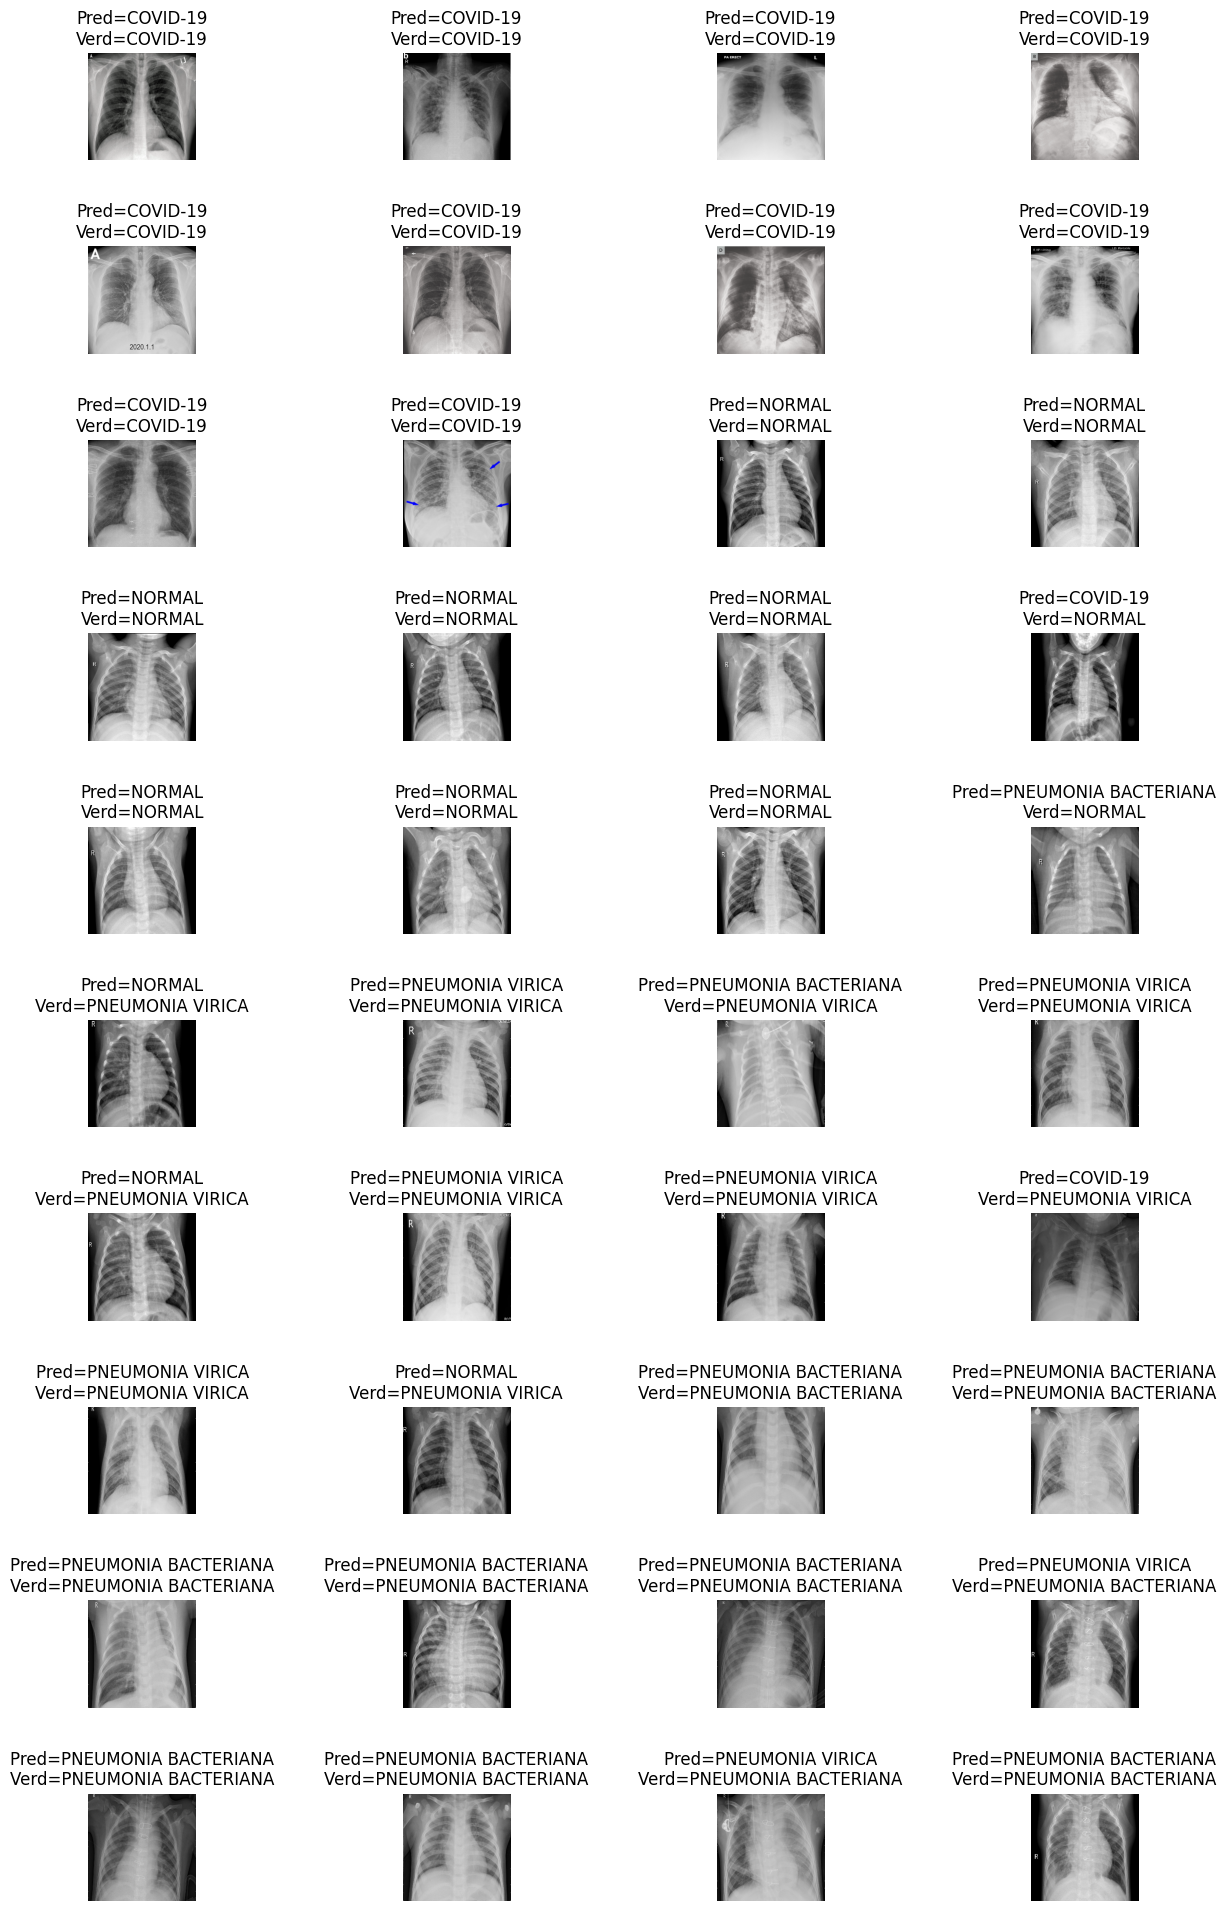

In [ ]:
# realizamos una comparacion entre las predicciones y las clases originales

L = 10
W = 4

fig, axes = plt.subplots(L, W, figsize = (14, 24))
axes = axes.ravel()

for i in np.arange(0, L * W):
  axes[i].imshow(image[i])
  axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[predictions[i]]), str(label_names[original[i]])))
  axes[i].axis('off')

plt.subplots_adjust(wspace=1.2, hspace=0.8)
plt.show()

In [ ]:
# Realizamos una comparación entre las predicciones y las clases originales

print(classification_report(np.asarray(original), np.asarray(predictions)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.73      0.80      0.76        10
           2       0.71      0.50      0.59        10
           3       0.80      0.80      0.80        10

    accuracy                           0.78        40
   macro avg       0.77      0.77      0.76        40
weighted avg       0.77      0.78      0.76        40



#Resumen de las predicciones

De la respuesta dada, se puede concluir lo siguiente:

* La clase 0 tiene la mayor precisión (0.83) y recuperación (1.00), lo que indica que el modelo es muy bueno para predecir correctamente esta clase y no se pierde muchos ejemplos positivos de esta clase.

* La clase 2 tiene la menor precisión (0.71) y recuperación (0.50), lo que indica que el modelo tiene más dificultades para predecir correctamente esta clase y se pierde muchos ejemplos positivos de esta clase.

* La precisión promedio ponderada y la puntuación F1 promedio ponderada son ambas 0.77, lo que indica que el modelo tiene un rendimiento general decente en la predicción de todas las clases.

* La precisión general del modelo es 0.78, lo que indica que el modelo predice correctamente el 78% de los ejemplos en el conjunto de validación.


En resumen, el modelo parece tener un buen rendimiento en general, pero tiene más dificultades para predecir correctamente la clase 2 (se pueden realizar pruebas adicionales para mejorar el rendimiento del modelo, lo ideal es tener muchas mas imagenes para mejorar las predicciones).

Text(0.5, 1.0, 'Matriz de confusión')

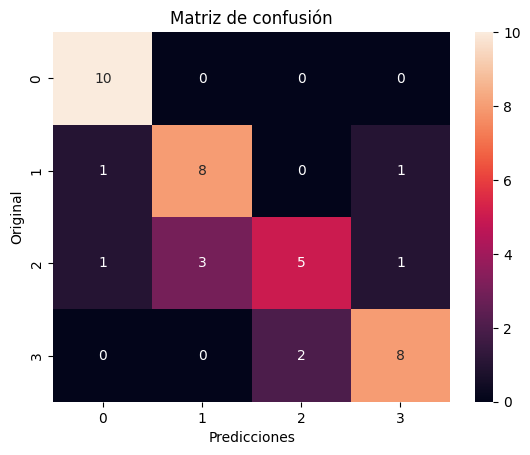

In [ ]:
# Graficamos una matriz de confusión para observar la exactitud del modelo

cm = confusion_matrix(np.asarray(original), np.asarray(predictions))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Original')
ax.set_title('Matriz de confusión')